In [79]:
from src.data_utils import load_xsum_dict, load_shuffled_test_split

xsum_test = load_xsum_dict("test")
bart_test_extrinsic = load_shuffled_test_split(xsum_test, "bart-test-extrinsic", len(xsum_test))
print(
    len(bart_test_extrinsic),
    len(bart_test_extrinsic) / len(xsum_test)
)
pegasus_test_extrinsic = load_shuffled_test_split(xsum_test, "pegasus-test-extrinsic", len(xsum_test))
print(
    len(pegasus_test_extrinsic),
    len(pegasus_test_extrinsic) / len(xsum_test)
)

Using custom data configuration default
Reusing dataset xsum (/Users/anton164/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

6823 0.6019940003529204
6988 0.6165519675313217


In [192]:
import pandas as pd
import json

ent_type_map = {
    "DATE": "Date",
    "PERSON": "Person",
    "PERSON": "Person",
    "GPE": "Location",
    "LOC": "Location",
    "CARDINAL": "Numeric",
    "MONEY": "Numeric",
    "ORDINAL": "Numeric",
    "FAC": "FAC",
    "ORG": "ORG"
}

def map_entity_type(ent_type):
    if ent_type in ent_type_map:
        return ent_type_map[ent_type]
    else:
        return ent_type


def read_logs(path):
    with open(
        path,
        "r"
    ) as f:
        iteration_logs = json.load(f)

    data = []
    for iteration in iteration_logs:
        for ent_type in iteration["factuality_entities"]["type"].keys():
            ent_stats = iteration["factuality_entities"]["type"][ent_type]
            result_obj = {
                "iteration": iteration["iteration"],
                "entity_type": ent_type,
                "total": ent_stats["total"],
                "extrinsic_factual": ent_stats["Factual Hallucination"] if "Factual Hallucination" in ent_stats else 0,
                "extrinsic_non_factual": ent_stats["Non-factual Hallucination"] if "Non-factual Hallucination" in ent_stats else 0,
                "intrinsic_factual": ent_stats["Non-hallucinated"] if "Non-hallucinated" in ent_stats else 0,
                "intrinsic_non_factual": ent_stats["Intrinsic Hallucination"] if "Intrinsic Hallucination" in ent_stats else 0,
                "unknown": ent_stats["Unknown"] if "Unknown" in ent_stats else 0,
            }
            data.append(result_obj)
    
    df = pd.DataFrame(data).set_index("iteration")
    df["annotated"] = df["total"] - df["unknown"]
    return df, iteration_logs

dataset = "bart-test-extrinsic-100"
df_clf, logs_clf = read_logs(
    f"results/iteration-changes/{dataset}-classifier-knnv1.json"
)

df_clf

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,CARDINAL,21,6,6,7,2,0,21
0,DATE,35,8,20,7,0,0,35
0,EVENT,7,4,0,3,0,0,7
0,FAC,6,3,1,2,0,0,6
0,GPE,75,17,12,44,2,0,75
...,...,...,...,...,...,...,...,...
9,ORG,62,18,9,34,1,0,62
9,PERCENT,3,0,0,2,1,0,3
9,PERSON,110,22,17,65,6,0,110


In [193]:
df_clf.loc[0].sort_values("extrinsic_non_factual", ascending=False)

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,DATE,35,8,20,7,0,0,35
0,PERSON,120,28,20,68,4,0,120
0,GPE,75,17,12,44,2,0,75
0,CARDINAL,21,6,6,7,2,0,21
0,ORG,58,17,5,34,2,0,58
0,ORDINAL,8,4,3,1,0,0,8
0,MONEY,4,1,2,1,0,0,4
0,FAC,6,3,1,2,0,0,6
0,LOC,2,0,1,1,0,0,2


In [194]:
df_clf[df_clf.entity_type == "PERSON"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,PERSON,120,28,20,68,4,0,120
1,PERSON,116,24,17,58,5,12,104
2,PERSON,113,23,18,63,5,4,109
3,PERSON,112,22,17,62,6,5,107
4,PERSON,112,22,18,66,6,0,112
5,PERSON,110,22,17,65,6,0,110
6,PERSON,110,22,17,65,6,0,110
7,PERSON,110,22,17,65,6,0,110
8,PERSON,110,22,17,65,6,0,110


In [195]:
df_clf[df_clf.entity_type == "GPE"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,GPE,75,17,12,44,2,0,75
1,GPE,69,12,9,42,1,5,64
2,GPE,74,13,10,45,2,4,70
3,GPE,73,14,7,45,2,5,68
4,GPE,72,15,9,46,2,0,72
5,GPE,70,15,8,45,2,0,70
6,GPE,71,14,8,45,2,2,69
7,GPE,71,14,8,45,2,2,69
8,GPE,71,14,8,45,2,2,69


In [179]:
df_clf[df_clf.entity_type == "ORG"]

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated
iteration,,,,,,,,
0,ORG,58,17,5,34,2,0,58
1,ORG,60,18,7,28,1,6,54
2,ORG,62,17,5,32,1,7,55
3,ORG,61,17,7,34,1,2,59
4,ORG,60,18,7,34,1,0,60
5,ORG,63,18,10,34,1,0,63
6,ORG,62,18,9,34,1,0,62
7,ORG,63,18,9,34,1,1,62
8,ORG,63,18,9,34,1,1,62


In [204]:
df_plot = df_clf[
    df_clf.entity_type.isin(["PERSON", "GPE", "ORG", "DATE", "CARDINAL"])
    & df_clf.index.isin([0, max(df_clf.index)])
]
df_plot.loc[:, "Model"] = "Baseline"
df_plot.loc[max(df_clf.index), "Model"] = "GEF"
df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
    df_plot["extrinsic_factual"] + df_plot["extrinsic_non_factual"]
)
df_plot.loc[:, "factual_ratio"] = (df_plot["extrinsic_factual"] + df_plot["intrinsic_factual"]) / (
    df_plot["total"]
)
df_plot

/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_71325/1707997999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "Model"] = "Baseline"
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_71325/1707997999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, "extrinsic_factual_ratio"] = df_plot["extrinsic_factual"] / (
/var/folders/yb/l4pdzll51k946vtlt23kftkh0000gn/T/ipykernel_71325/1707997999.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

,entity_type,total,extrinsic_factual,extrinsic_non_factual,intrinsic_factual,intrinsic_non_factual,unknown,annotated,Model,extrinsic_factual_ratio,factual_ratio
iteration,,,,,,,,,,,
0,CARDINAL,21,6,6,7,2,0,21,Baseline,0.500000,0.619048
0,DATE,35,8,20,7,0,0,35,Baseline,0.285714,0.428571
0,GPE,75,17,12,44,2,0,75,Baseline,0.586207,0.813333
0,ORG,58,17,5,34,2,0,58,Baseline,0.772727,0.879310
0,PERSON,120,28,20,68,4,0,120,Baseline,0.583333,0.800000
9,CARDINAL,22,7,6,7,2,0,22,GEF,0.538462,0.636364
9,DATE,26,7,9,9,1,0,26,GEF,0.437500,0.615385
9,GPE,71,14,10,45,2,0,71,GEF,0.583333,0.830986
9,ORG,62,18,9,34,1,0,62,GEF,0.666667,0.838710


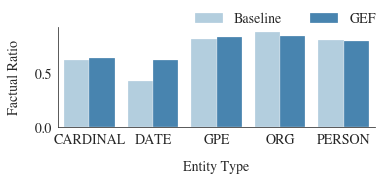

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt


fg = sns.catplot(
    x="entity_type", 
    y="factual_ratio", 
    hue="Model",
    kind="bar",
    data=df_plot,
    legend=False,
    height=2.75,
    palette="Blues",
    aspect=2,
    ci=None
)
FONT_SIZE = 14
fg.ax.set_xlabel("Entity Type", fontsize=FONT_SIZE, labelpad=FONT_SIZE)
fg.ax.set_ylabel("Factual Ratio", fontsize=FONT_SIZE, labelpad=FONT_SIZE)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
plt.legend(bbox_to_anchor=(1.02, 1.2), loc='upper right', borderaxespad=0, prop={'size': 14}, ncol=2)
plt.tight_layout()
plt.savefig("plots/entity_types.pdf")
# ax